In [1408]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score

In [1409]:
image_dir = Path('../age-prediction-dataset/20-50/20-50')

In [1410]:
image_dir

WindowsPath('../age-prediction-dataset/20-50/20-50')

In [1411]:
filepath = pd.Series(list(image_dir.glob(r'**/*.jpg')), name = 'Filepath').astype(str)

In [1412]:
filepath[0]

'..\\age-prediction-dataset\\20-50\\20-50\\test\\20\\28492.jpg'

In [1413]:
os.path.split(os.path.split(filepath.values[0])[0])[1]

'20'

In [1414]:
age = pd.Series(filepath.apply(lambda x :os.path.split(os.path.split(x)[0])[1]), name = 'Age').astype(np.int)

C:\Users\DELL\AppData\Local\Temp\ipykernel_13660\894484879.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  age = pd.Series(filepath.apply(lambda x :os.path.split(os.path.split(x)[0])[1]), name = 'Age').astype(np.int)


In [1415]:
images = pd.concat([filepath, age], axis = 1).sample(frac = 1.0,random_state = 42).reset_index(drop = True)

In [1416]:
images.head()

,Filepath,Age
0,..\age-prediction-dataset\20-50\20-50\train\42...,42
1,..\age-prediction-dataset\20-50\20-50\train\24...,24
2,..\age-prediction-dataset\20-50\20-50\train\34...,34
3,..\age-prediction-dataset\20-50\20-50\train\44...,44
4,..\age-prediction-dataset\20-50\20-50\test\31\...,31


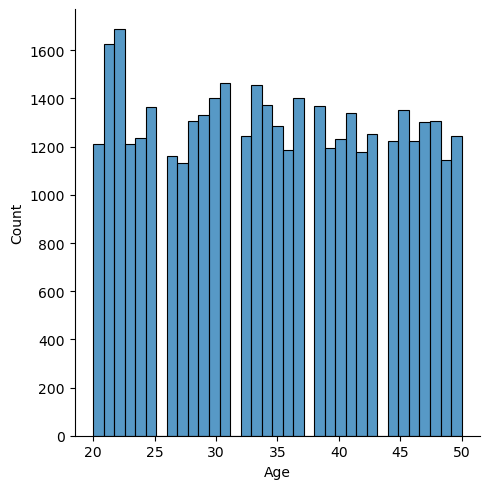

In [1417]:
sns.displot(images['Age'], kde=False)

In [1418]:
image_df = images.sample(6000, random_state =42).reset_index(drop=True)

In [1419]:
train_df, test_df = train_test_split(image_df, test_size = 0.3, shuffle = True,random_state = 42)

In [1420]:
print(train_df.shape)
print(test_df.shape)

(4200, 2)
(1800, 2)


In [1421]:
import os
import PIL

In [1422]:
train_df.head()

,Filepath,Age
4775,..\age-prediction-dataset\20-50\20-50\train\37...,37
927,..\age-prediction-dataset\20-50\20-50\train\27...,27
3258,..\age-prediction-dataset\20-50\20-50\train\27...,27
45,..\age-prediction-dataset\20-50\20-50\train\39...,39
1260,..\age-prediction-dataset\20-50\20-50\train\29...,29


In [1423]:
width,height = 1000,1000

In [1424]:
for t in train_df['Filepath']:
    img = PIL.Image.open(t)
    w, h = img.size
    if w < width:
        width = w
    if h < height:
        height = h

IMG_WIDTH = width
IMG_HEIGHT = height
IMG_CHANNELS = 3

In [1425]:
IMG_WIDTH

128

In [1426]:
IMG_HEIGHT

128

In [1427]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [1428]:
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    
)

In [1429]:
train_images = train_gen.flow_from_dataframe(
dataframe = train_df,
x_col = 'Filepath',
y_col = 'Age',
target = (120,120),
color_mode = 'rgb',
class_mode = 'raw',
batch_size = 32, 
shuffle = True,
seed = 42,
subset = 'training'
)

val_images = train_gen.flow_from_dataframe(
dataframe = train_df,
x_col = 'Filepath',
y_col = 'Age',
target = (120,120),
color_mode = 'rgb',
class_mode = 'raw',
batch_size = 32, 
shuffle = True,
seed = 42,
subset = 'validation'
)

test_images = test_gen.flow_from_dataframe(
dataframe = test_df,
x_col = 'Filepath',
y_col = 'Age',
target = (120,120),
color_mode = 'rgb',
class_mode = 'raw',
batch_size = 32, 
shuffle = False
)

Found 3360 validated image filenames.
Found 840 validated image filenames.
Found 1800 validated image filenames.


In [1430]:
Inputs = tf.keras.Input((120,120,3))
x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu')(Inputs)

In [1433]:
x=tf.keras.layers.BatchNormalization()(x)

In [1434]:
x = tf.keras.layers.AveragePooling2D()(x)

In [1435]:
x = tf.keras.layers.Dropout(0.3)(x)

In [1437]:
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')(x)

In [1438]:
x=tf.keras.layers.BatchNormalization()(x)

In [1439]:
x = tf.keras.layers.AveragePooling2D()(x)

In [1441]:
x = tf.keras.layers.Dropout(0.3)(x)

In [1442]:
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')(x)

In [1443]:
x=tf.keras.layers.BatchNormalization()(x)

In [1444]:
x = tf.keras.layers.MaxPool2D()(x)

In [1445]:
x =tf.keras.layers.Dropout(0.2)(x)

In [1448]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [1449]:
#x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(32, activation = 'relu')(x)

In [1451]:
output = tf.keras.layers.Dense(1, activation = 'linear')(x)

In [1452]:
output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_87')>

In [1453]:
model = tf.keras.Model(inputs = Inputs, outputs = output)

In [1454]:
model.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_75 (Conv2D)          (None, 118, 118, 16)      448       
                                                                 
 batch_normalization_37 (Bat  (None, 118, 118, 16)     64        
 chNormalization)                                                
                                                                 
 average_pooling2d_31 (Avera  (None, 59, 59, 16)       0         
 gePooling2D)                                                    
                                                                 
 dropout_2 (Dropout)         (None, 59, 59, 16)        0         
                                                                 
 conv2d_76 (Conv2D)          (None, 57, 57, 32)        464

In [1455]:
from keras.optimizers import Adam

In [1456]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
              loss=tf.keras.losses.MeanSquaredError(),
             metrics = [tf.keras.metrics.MeanAbsoluteError()])

In [1457]:
#history = model.fit(train_images, validation_data = val_images, epochs = 5
                   

history = model.fit(train_images, validation_data = val_images, epochs = 20,
                    callbacks = [
                        tf.keras.callbacks.EarlyStopping(
                        monitor = 'val_loss',
                        patience = 5,
                        restore_best_weights = True)
                    ]
                   )

Epoch 1/20
105/105 [==============================] - 288s 3s/step - loss: 179.6449 - mean_absolute_error: 10.4041 - val_loss: 305.8795 - val_mean_absolute_error: 15.0416
Epoch 2/20
105/105 [==============================] - 286s 3s/step - loss: 84.2658 - mean_absolute_error: 7.8505 - val_loss: 127.9858 - val_mean_absolute_error: 9.3937
Epoch 3/20
105/105 [==============================] - 286s 3s/step - loss: 84.8631 - mean_absolute_error: 7.8731 - val_loss: 168.2803 - val_mean_absolute_error: 10.7515
Epoch 4/20
105/105 [==============================] - 286s 3s/step - loss: 82.8176 - mean_absolute_error: 7.7768 - val_loss: 85.9700 - val_mean_absolute_error: 7.8249
Epoch 5/20
105/105 [==============================] - 283s 3s/step - loss: 82.1417 - mean_absolute_error: 7.7496 - val_loss: 120.2478 - val_mean_absolute_error: 9.1856
Epoch 6/20
105/105 [==============================] - 275s 3s/step - loss: 83.6109 - mean_absolute_error: 7.8118 - val_loss: 86.4634 - val_mean_absolute_erro

In [1458]:
train_df.dtypes

Filepath    object
Age          int32
dtype: object

In [1459]:
predicted_ages = np.squeeze(model.predict(test_images))
true_ages = test_images.labels

57/57 [==============================] - 43s 741ms/step


In [1461]:
rmse

array([8.96335857, 2.77724657])

In [1463]:
null_rmse = np.sqrt(np.sum((true_ages - np.mean(true_ages))**2) / len(true_ages))
print("Null/Baseline Model Test RMSE: {:.5f}".format(null_rmse))

Null/Baseline Model Test RMSE: 8.87110
